In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pyproj

geodesic = pyproj.Geod(ellps='WGS84')

# Load drifter

In [ ]:
fn='/content/drive/Shareddrives/Coastal/FFT challenge/data/data_up_to_21_Nov.csv'
path='/content/drive/Shareddrives/Coastal/FFT challenge/data/'
d = pd.read_csv(fn)
idr = d['spotId']
k =50# number of drifter
fout=open("/content/drive/Shareddrives/Coastal/FFT challenge/drifter_{}.txt".format(idr.unique()[k]),'w')
fout.write("uw vw sh dpx dpy pp u v f dx dy\n")
df=d.loc[lambda d: d.spotId==idr.unique()[k],:]
current = np.loadtxt(path + "ocean_current_{}.txt".format(idr.unique()[k]),skiprows=1)
wind = np.loadtxt(path + "air_wave_{}.txt".format(idr.unique()[k]),skiprows=1)
data=[]
sgx=1
sgy=1
for Nd in range(len(df)-1):
  dt = df['epoch [s]'].iloc[Nd+1]-df['epoch [s]'].iloc[Nd]
  x1 = df.longitude.iloc[Nd]
  x2 = df.longitude.iloc[Nd+1]
  if (x2-x1)<0:
    sgx=-1
  y1 = df.latitude.iloc[Nd]
  y2 = df.latitude.iloc[Nd+1]
  if (y2-y1)<0:
    sgy=-1
  pdx = geodesic.inv(x1, y1, x2, y1) #calculate dx using geodesic
  dx = pdx[2]*sgx
  pdy = geodesic.inv(x1, y1, x1, y2) #calculate dy using geodesic
  dy = pdy[2]*sgy
  uw = (wind[Nd,1] + wind[Nd+1,1])/2 # u-comp. wind
  vw = (wind[Nd,2] + wind[Nd+1,2])/2 # v-comp. wind
  sh = (wind[Nd,3] + wind[Nd+1,3])/2 # sign. height
  dp = (wind[Nd,4] + wind[Nd+1,4])/2 # primary direction
  pp = (wind[Nd,5] + wind[Nd+1,5])/2 # primary period
  dpx = 1*np.cos(dp) #x-component of wave primary direction
  dpy = 1*np.sin(dp) #y-component of wave primary direction
  u = (current[Nd,1] + current[Nd+1,1])/2 # u-comp. wind
  v = (current[Nd,2] + current[Nd+1,2])/2 # v-comp. wind
  f =np.sin((y2-y1)/2)  # Coriolis mimic
  if dt==3600:
    fout.write("%3.3f %3.3f %3.3f %3.3f %3.3f %3.3f %3.3f %3.3f %3.3f %3.3f %3.3f\n"%(uw,vw,sh,dpx,dpy,pp,u,v,f,dx,dy))
fout.close()

# Delta prediction

Testing set Mean Abs Error: 155.46 m


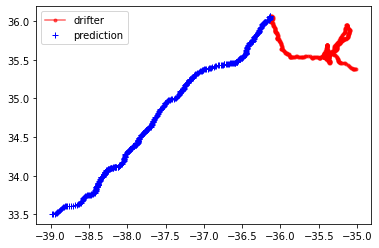

In [ ]:
#Load data and model
#data
path='/content/drive/Shareddrives/Coastal/FFT challenge/'
Dataset = pd.read_csv(path+'data_delta.txt',delimiter=' ')
Dataset = Dataset.dropna() #Drop values with NAN values
# #Separating data Train and Test, features and labels
train_dataset = Dataset.sample(frac=0.8,random_state=1)
test_dataset = Dataset.drop(train_dataset.index)
lbl = ['dx','dy']
train_labels = pd.DataFrame([train_dataset.pop(x) for x in lbl]).T
test_labels  = pd.DataFrame([test_dataset.pop(x) for x in lbl]).T
#Normalization
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
def norm(x):
    return(x-train_stats['mean'])/train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

fn="drifter_{}.txt".format(idr.unique()[k])
ds = pd.read_csv(path+fn,delimiter=' ')
ds = ds.dropna() #Drop values with NAN values
# #Separating data Train and Test, features and labels
lbl = ['dx','dy']
for x in lbl:
  ds.pop(x)
Normed_data = norm(ds)

#Load model
model = keras.models.load_model(path+'model_delta')
loss, mae, mse = model.evaluate(normed_test_data,test_labels,verbose=0)
print("Testing set Mean Abs Error: {:5.2f} m".format(mae))
pred=[]
for i in range(len(Normed_data)):
    nep = Normed_data.iloc[i].values
    nep = nep.reshape(1,9)
    prediction = model.predict(nep)
    pred.append((prediction[0][0],prediction[0][1]))
pred=np.array(pred)
####plot results
import pyproj
import matplotlib.pyplot as plt
geodesic = pyproj.Geod(ellps='WGS84')

x=df.longitude.iloc[0]
y=df.latitude.iloc[0]
fcx = geodesic.inv(x, y, x+1, y)
fcx = abs(fcx[2])
fcy = geodesic.inv(x, y, x, y+1)
fcy = abs(fcy[2])
pos=[]
for i in range(len(pred)-1):
  #update position
  dx = pred[i,0]
  dy = pred[i,1]

  x = x + dx/fcx
  y = y + dy/fcy
  pos.append((x,y))

dat = np.array(pos)
plt.plot(df.longitude.values,df.latitude.values,color='r',marker='.',label='drifter',alpha=0.6)
plt.plot(dat[:,0],dat[:,1],'b+',label='prediction',zorder=10)
plt.legend()

#Load data to predict for challenge
*   Nov24-12pm 1637755200
*   Nov26-12pm 1637928000
*   Nov28-12pm 1638100800
*   Nov30-12pm 1638273600
*   Dic02-12pm 1638446400

In [ ]:
import datetime
from datetime import timedelta
start_time = datetime.datetime(1970,1,1,0,0,0)
delta = timedelta(seconds=1637514000+24*3600)
to= start_time + delta
epoc=1637514000+24*3600
print(to,epoc)
for i in range(5):
  dt = timedelta(seconds=24*2*3600)
  epoc = epoc + dt.total_seconds()
  to =to + dt
  print (to, epoc)

In [ ]:
import datetime
from datetime import timedelta
fn='/content/drive/Shareddrives/Coastal/FFT challenge/data_22_Nov.csv'
path='/content/drive/Shareddrives/Coastal/FFT challenge/data/'
d = pd.read_csv(fn)
idr = d['spotId']
idr = idr.unique() # the identifiers of each drifter
start_time = datetime.datetime(1970,1,1,0,0,0)
for i in range(len(idr)):
  df=d.loc[lambda d: d.spotId==idr[k],:]
print(d.iloc[960])
dt=timedelta(seconds=d['epoch [s]'].iloc[960])
fecha = start_time+dt
print(fecha)
print(d['epoch [s]'].iloc[960])
